In [435]:
import pandas as pd
import numpy as np

In [436]:
raw_data = pd.read_csv('data_lab6.csv')

# select random sqrt(n) columns
n = len(raw_data.columns)
sqrt_n = int(np.sqrt(n))
raw_data['GRADE_CLASS'] = raw_data['GRADE'].apply(lambda x: 1 if x >= 4 else 0)
raw_data.drop('GRADE', axis=1, inplace=True)
data = raw_data.sample(n=sqrt_n, axis=1)
data['GRADE_CLASS'] = raw_data['GRADE_CLASS']
data.head()

,COURSE ID,2,17,7,21,GRADE_CLASS
0,1,2,3,2,1,0
1,1,2,2,2,1,0
2,1,2,2,2,1,0
3,1,1,3,1,1,0
4,1,2,2,1,1,0


In [437]:
data.describe()

,COURSE ID,2,17,7,21,GRADE_CLASS
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,4.131034,1.600000,2.200000,1.579310,1.206897,0.393103
std,3.260145,0.491596,0.917424,0.495381,0.588035,0.490133
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,3.000000,2.000000,2.000000,2.000000,1.000000,0.000000
75%,7.000000,2.000000,3.000000,2.000000,1.000000,1.000000
max,9.000000,2.000000,5.000000,2.000000,3.000000,1.000000


In [438]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   COURSE ID    145 non-null    int64
 1   2            145 non-null    int64
 2   17           145 non-null    int64
 3   7            145 non-null    int64
 4   21           145 non-null    int64
 5   GRADE_CLASS  145 non-null    int64
dtypes: int64(6)
memory usage: 6.9 KB


<Axes: >

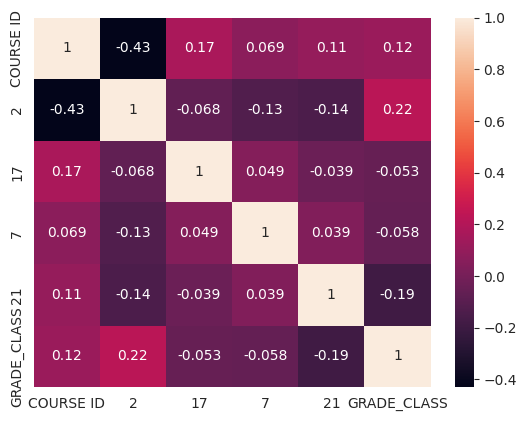

In [448]:
import seaborn as sns

sns.heatmap(data.corr(), annot=True)

<Figure size 640x480 with 0 Axes>

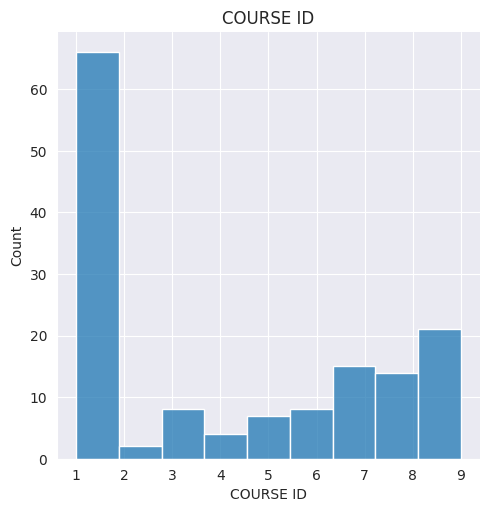

<Figure size 640x480 with 0 Axes>

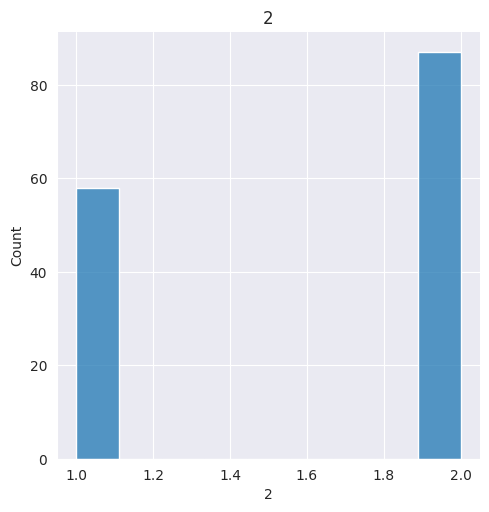

<Figure size 640x480 with 0 Axes>

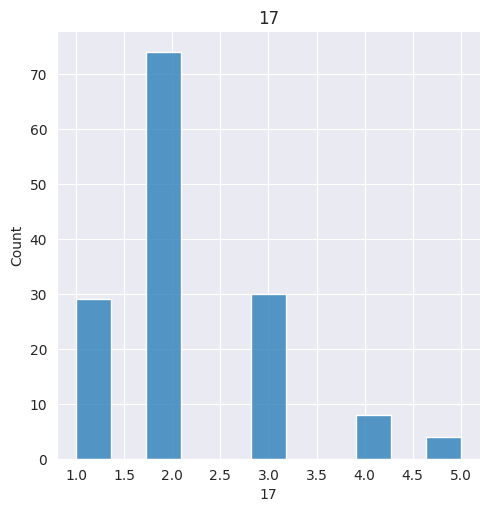

<Figure size 640x480 with 0 Axes>

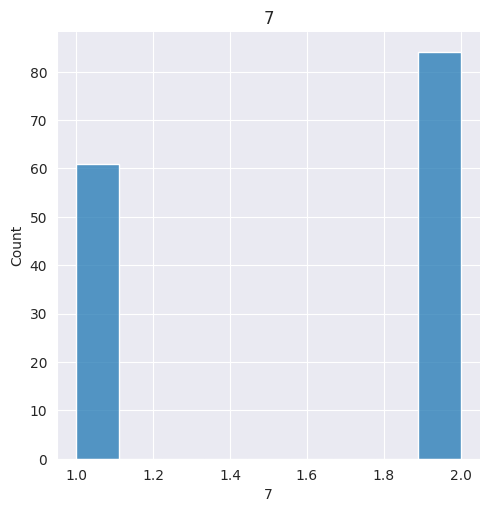

<Figure size 640x480 with 0 Axes>

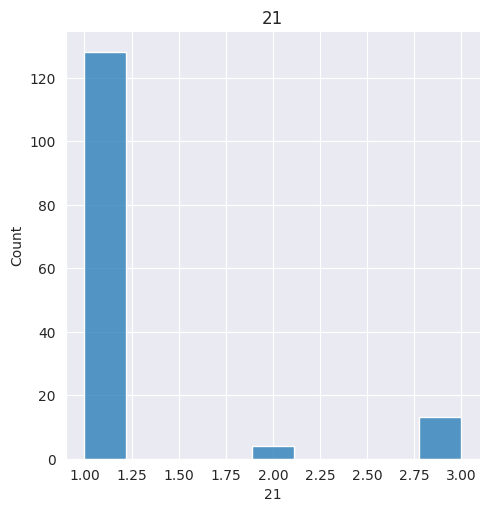

<Figure size 640x480 with 0 Axes>

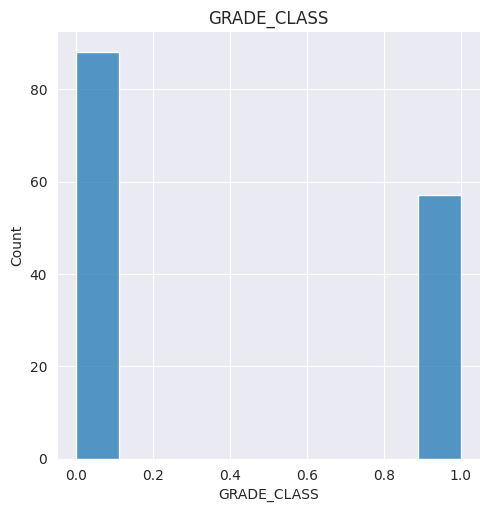

In [449]:
from matplotlib import pyplot as plt

for col in data.columns:
    plt.figure()
    sns.displot(data[col])
    plt.title(col)
    plt.show()

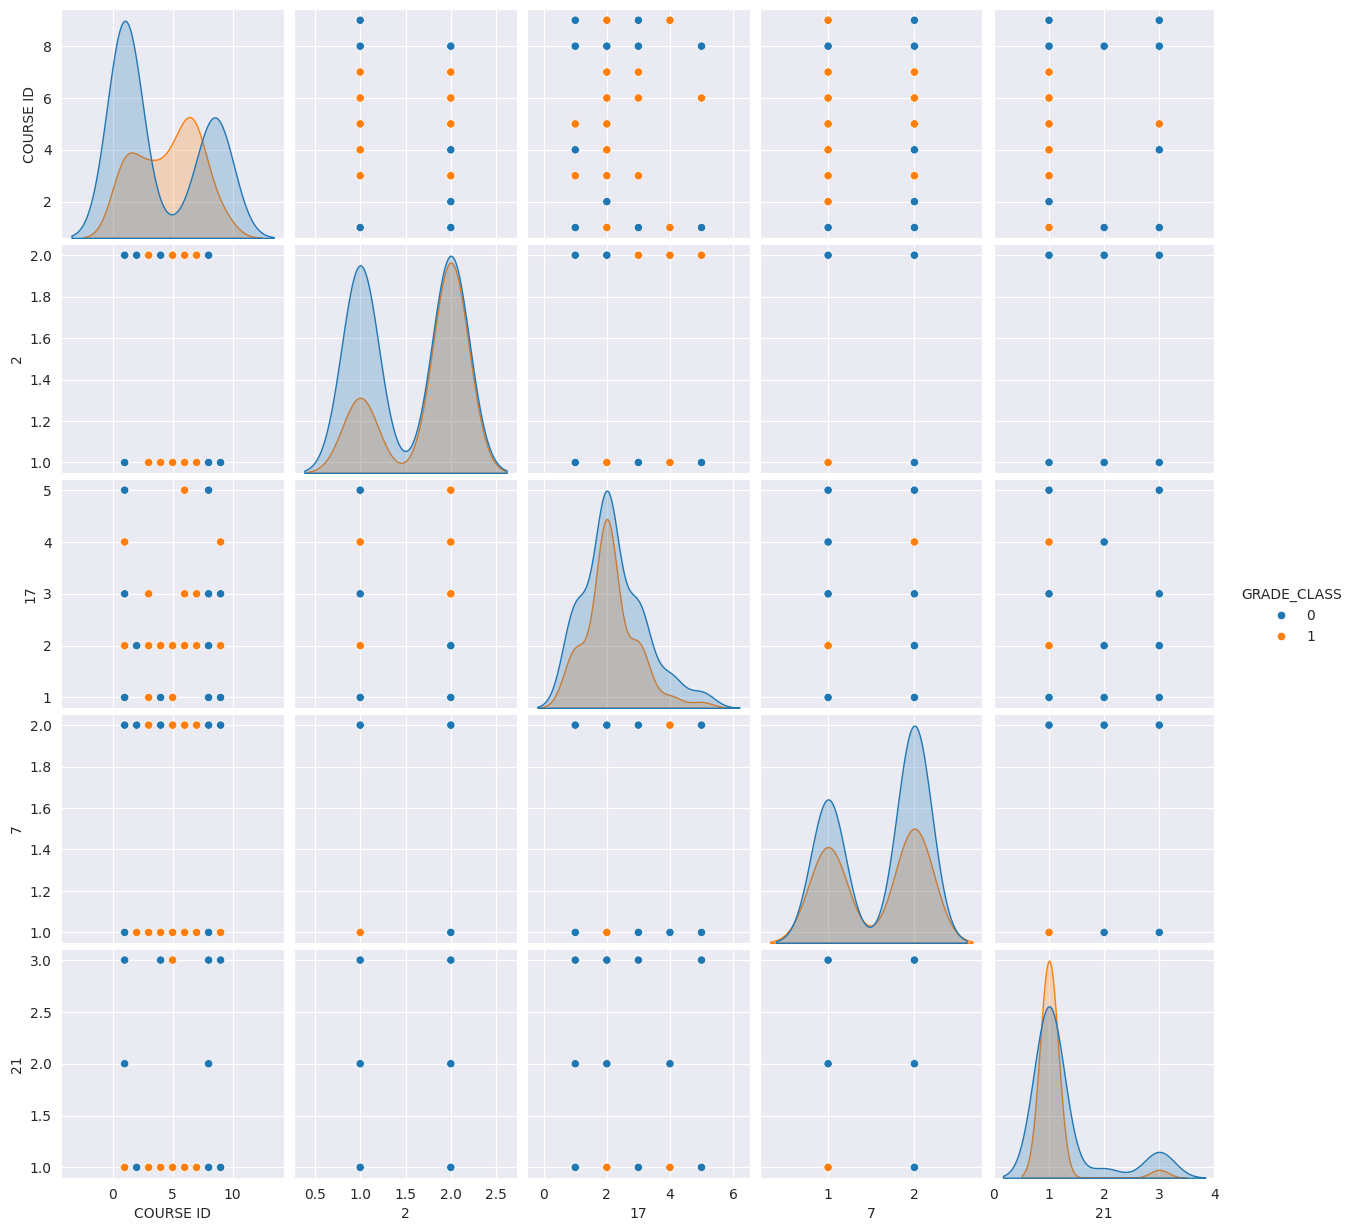

In [441]:
sns.pairplot(data, hue='GRADE_CLASS')

In [442]:
# implement decision tree using C 4.5 algorithm

def entropy(y):
    if len(y) == 0:
        return 0
    p = y.value_counts() / len(y)
    return -np.sum(p * np.log2(p))


class DecisionTreeNode:
    def __init__(self, feature: str, children: dict[str, 'DecisionTreeNode'], probability: float):
        self.feature = feature
        self.children = children
        self.probability = probability

    def predict(self, x):
        if self.probability is not None:
            return self.probability
        elif self.feature in x.keys() and x[self.feature] in self.children.keys():
            return self.children[x[self.feature]].predict(x)
        else:
            return 0

    def to_string(self, level=0):
        if self.probability is not None:
            print(f'{"__" * level}(): {self.probability}')
        else:
            for value, child in self.children.items():
                print(f'{"__" * level}({self.feature} == {value})')
                child.to_string(level + 1)

class DecisionTree:
    def __init__(self):
        self.root = None

    def fit(self, x, y, max_depth=5):
        self.root: DecisionTree = self.build_tree(x, y)

    def build_tree(self, x, y, curr_depth=0, max_depth=5):
        if len(y.unique()) == 1 or curr_depth == max_depth:
            has_passed = False
            if len(y.unique()) == 1:
                has_passed = y.unique()[0] == 1
            else:
                has_passed = True
            if not has_passed:
                return DecisionTreeNode(None, None, 0)
            passed_count = y.value_counts()[1]
            return DecisionTreeNode(None, None, passed_count / len(y))
        else:
            best_feature_by_entropy = None
            best_gain = 0

            for feature in x.columns:
                feature_weights = x[feature].value_counts() / len(x)
                curr_entropy = 0
                for value in feature_weights.index:
                    leaf = y[x[feature] == value]
                    curr_entropy += feature_weights[value] * entropy(leaf)
                gain = entropy(y) - curr_entropy
                if gain > best_gain:
                    best_gain = gain
                    best_feature_by_entropy = feature
                    
            if best_feature_by_entropy is None:
                passed_count = y.value_counts()[1]
                return DecisionTreeNode(None, None, passed_count / len(y))
            
            return self.build_tree_by_feature(x, y, best_feature_by_entropy)
            
    def build_tree_by_feature(self, x, y, feature) -> DecisionTreeNode:
        children: dict[str, 'DecisionTreeNode'] = {}
        for value in x[feature].unique():
            children[value] = self.build_tree(x[x[feature] == value], y[x[feature] == value])
        return DecisionTreeNode(feature, children, None)
                
    def predict(self, x):
        return self.root.predict(x)


In [443]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data.drop('GRADE_CLASS', axis=1), data['GRADE_CLASS'],
                                                    test_size=0.2, random_state=42, stratify=data['GRADE_CLASS'])

In [444]:
tree = DecisionTree()
tree.fit(x_train, y_train)
tree.root.to_string()

(COURSE ID == 9)
__(17 == 4)
____(7 == 2)
______(): 0.3333333333333333
____(7 == 1)
______(): 0
__(17 == 3)
____(7 == 1)
______(): 0
____(7 == 2)
______(): 0.5
__(17 == 2)
____(): 0
__(17 == 1)
____(): 0
(COURSE ID == 1)
__(17 == 4)
____(): 0
__(17 == 2)
____(2 == 2)
______(21 == 1)
________(7 == 1)
__________(): 0.2727272727272727
________(7 == 2)
__________(): 0.2222222222222222
______(21 == 3)
________(): 0
____(2 == 1)
______(): 0
__(17 == 1)
____(2 == 1)
______(7 == 2)
________(): 0.25
______(7 == 1)
________(): 0.3333333333333333
____(2 == 2)
______(7 == 1)
________(): 0.25
______(7 == 2)
________(): 0
__(17 == 3)
____(21 == 1)
______(7 == 2)
________(): 0
______(7 == 1)
________(2 == 2)
__________(): 0.25
________(2 == 1)
__________(): 0
____(21 == 3)
______(2 == 2)
________(): 1.0
______(2 == 1)
________(): 0
__(17 == 5)
____(): 0
(COURSE ID == 8)
__(): 0
(COURSE ID == 7)
__(2 == 2)
____(): 1.0
__(2 == 1)
____(): 0.5
(COURSE ID == 6)
__(): 1.0
(COURSE ID == 3)
__(): 1.0
(COURSE

In [445]:
y_pred = []
for i in range(len(x_test)):
    y_pred.append(tree.predict(x_test.iloc[i]))
y_pred = np.array(y_pred)

y_pred

array([1.        , 0.25      , 0.25      , 0.5       , 0.        ,
       0.        , 0.22222222, 0.        , 1.        , 0.        ,
       1.        , 0.        , 0.22222222, 1.        , 0.        ,
       0.22222222, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 1.        ,
       0.        , 0.25      , 0.        , 0.27272727])

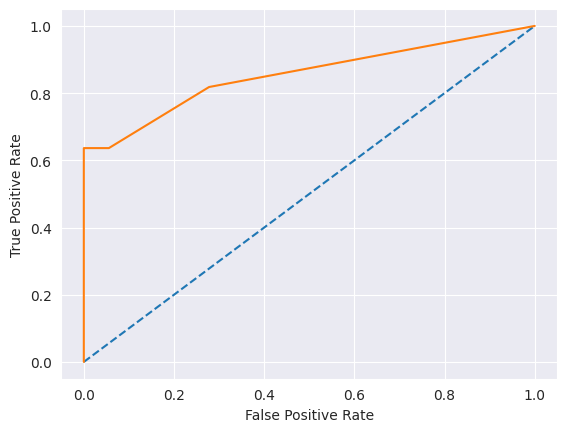

In [446]:
def compute_roc_curve(y_true, y_pred):
    thresholds = np.linspace(0, 1.1, 100)
    tpr = []
    fpr = []
    for threshold in thresholds:
        y_pred_class = y_pred >= threshold
        tp = np.sum((y_pred_class == 1) & (y_true == 1))
        fp = np.sum((y_pred_class == 1) & (y_true == 0))
        tn = np.sum((y_pred_class == 0) & (y_true == 0))
        fn = np.sum((y_pred_class == 0) & (y_true == 1))
        if tp + fn == 0:
            tpr.append(1)
        else:
            tpr.append(tp / (tp + fn))
        if fp + tn == 0:
            fpr.append(1)
        else:
            fpr.append(fp / (fp + tn))

    return tpr, fpr


tpr, fpr = compute_roc_curve(y_test, y_pred)

import matplotlib.pyplot as plt

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--')

plt.plot(fpr, tpr)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

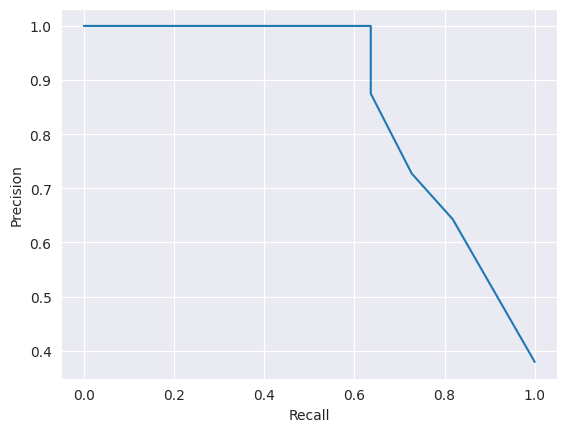

In [447]:
def compute_auc_pr(y_true, y_pred):
    thresholds = np.linspace(0, 1.1, 100)
    precision = []
    recall = []
    for threshold in thresholds:
        y_pred_class = y_pred >= threshold
        tp = np.sum((y_pred_class == True) & (y_true == True))
        fp = np.sum((y_pred_class == True) & (y_true == False))
        fn = np.sum((y_pred_class == False) & (y_true == True))
        if tp + fp == 0:
            precision.append(1)
        else:
            precision.append(tp / (tp + fp))
        if tp + fn == 0:
            recall.append(1)
        else:
            recall.append(tp / (tp + fn))

    return precision, recall


precision, recall = compute_auc_pr(y_test, y_pred)

plt.plot(recall, precision)

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show()